In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')
from datetime import datetime, timedelta

In [27]:
start_date = datetime(2020, 3, 1)
end_date = datetime.today() - timedelta(days=1)

In [28]:
df_cases = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

def clean_indices(df):
    df = df.set_index(['Province/State', 'Country/Region', 'Lat', 'Long'])
    df.columns = pd.to_datetime(df.columns)
    df = df.T[start_date:]
    return df

df_cases = clean_indices(df_cases)
df_deaths = clean_indices(df_deaths)
df_cases[:3]

Province/State         NaN                                                  \
Country/Region Afghanistan     Albania     Algeria     Andorra      Angola   
Lat              33.000000   41.153300   28.033900   42.506300  -11.202700   
Long            65.000000   20.168300   1.659600    1.521800    17.873900    
2020-03-01               1           0           1           0           0   
2020-03-02               1           0           3           1           0   
2020-03-03               1           0           5           1           0   

Province/State                                              \
Country/Region Antigua and Barbuda   Argentina     Armenia   
Lat                      17.060800  -38.416100   40.069100   
Long                   -61.796400  -63.616700   45.038200    
2020-03-01                       0           0           1   
2020-03-02                       0           0           1   
2020-03-03                       0           1           1   

Province/State Australian Capital Territory New South Wales  ...  \
Country/Region                    Australia       Australia  ...   
Lat                              -35.473500      -33.868800  ...   
Long                             149.012400      151.209300  ...   
2020-03-01                                0               6  ...   
2020-03-02                                0               6  ...   
2020-03-03                                0              13  ...   

Province/State Bonaire, Sint Eustatius and Saba         NaN  \
Country/Region                      Netherlands      Malawi   
Lat                                   12.178400  -13.254308   
Long                                -68.238500   34.301525    
2020-03-01                                    0           0   
2020-03-02                                    0           0   
2020-03-03                                    0           0   

Province/State Falkland Islands (Malvinas) Saint Pierre and Miquelon  \
Country/Region              United Kingdom                    France   
Lat                             -51.796300                 46.885200   
Long                           -59.523600                -56.315900    
2020-03-01                               0                         0   
2020-03-02                               0                         0   
2020-03-03                               0                         0   

Province/State         NaN                                                   \
Country/Region South Sudan Western Sahara Sao Tome and Principe       Yemen   
Lat              6.877000       24.215500             0.186360    15.552727   
Long            31.307000     -12.885800             6.613081    48.516388    
2020-03-01               0              0                     0           0   
2020-03-02               0              0                     0           0   
2020-03-03               0              0                     0           0   

Province/State                          
Country/Region     Comoros  Tajikistan  
Lat             -11.645500   38.861034  
Long            43.333300   71.276093   
2020-03-01               0           0  
2020-03-02               0           0  
2020-03-03               0           0  

[3 rows x 266 columns]

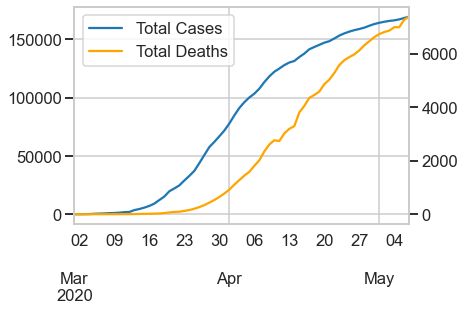

In [29]:
df_cases.xs('Germany', level='Country/Region', axis=1).plot(legend=False)
ax = plt.gca()
ax2 = ax.twinx()
df_deaths.xs('Germany', level='Country/Region', axis=1).plot(color='Orange', ax=ax2, legend=False)
ax2.grid(False)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
_ = ax2.legend(lines + lines2, ['Total Cases', 'Total Deaths'], loc=0)

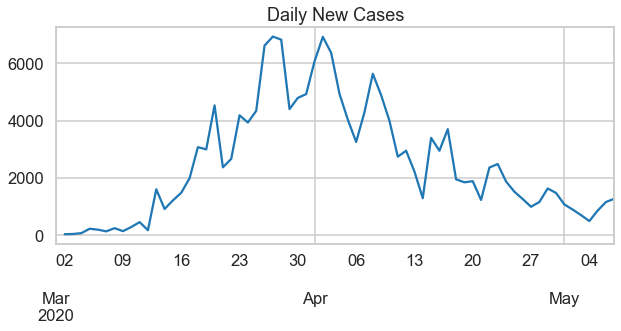

In [30]:
ger_cases = df_cases.xs('Germany', level='Country/Region', axis=1)
ger_daily = (ger_cases - ger_cases.shift(1))
_ = ger_daily.plot(title='Daily New Cases', figsize=(10,4), legend=False)

## RKI comparison

In [31]:
from os import walk
(_, _, filenames) = next(walk('./RKI data'))
file_names = [name for name in filenames if name.startswith('RKI_COVID19')]
file_names.sort()
df_raw = pd.read_csv('./RKI data/' + file_names[-1], parse_dates=['Meldedatum'])
df_rki = df_raw.copy()
ger_rki = df_rki.groupby('Meldedatum')[['AnzahlFall', 'AnzahlTodesfall']].sum()

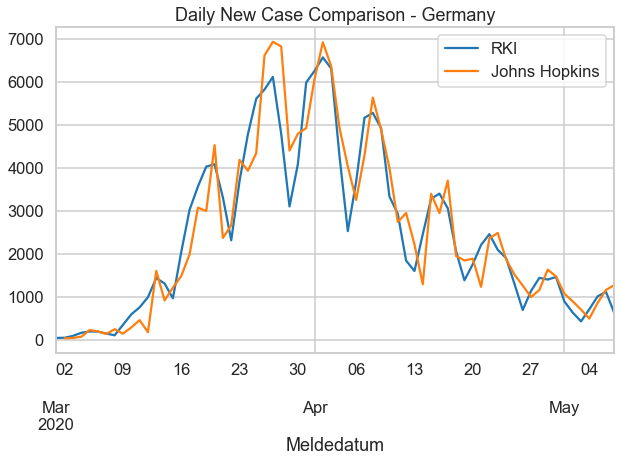

In [32]:
ax = ger_rki[start_date:]['AnzahlFall'].plot(figsize=(10, 6))
ger_daily.plot(ax=ax, legend=False)
plt.legend(['RKI', 'Johns Hopkins'])
_ = plt.title('Daily New Case Comparison - Germany')
#plt.yscale('log')

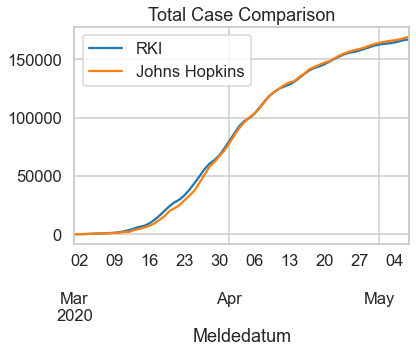

In [33]:
ax = ger_rki[start_date:]['AnzahlFall'].cumsum().plot()
ger_cases.plot(ax=ax, legend=False)
plt.legend(['RKI', 'Johns Hopkins'])
_ = plt.title('Total Case Comparison')

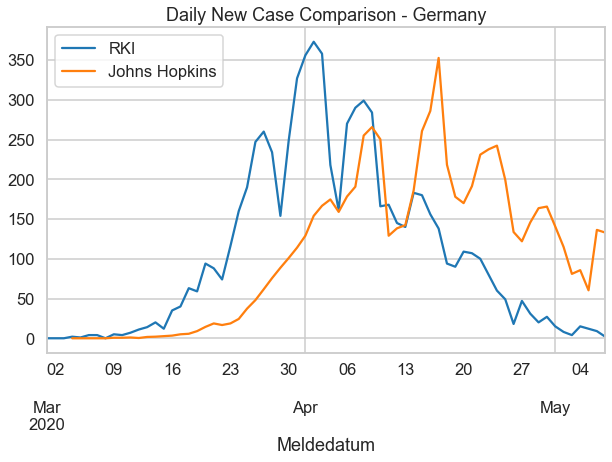

In [39]:
ger_deaths = df_deaths.xs('Germany', level='Country/Region', axis=1)
ger_daily_new_deaths = (ger_deaths - ger_deaths.shift(1)).rolling(3).mean()

ax = ger_rki[start_date:]['AnzahlTodesfall'].plot(figsize=(10, 6))
ger_daily_new_deaths.plot(ax=ax, legend=False)
plt.legend(['RKI', 'Johns Hopkins'])
_ = plt.title('Daily New Case Comparison - Germany')
#plt.yscale('log')

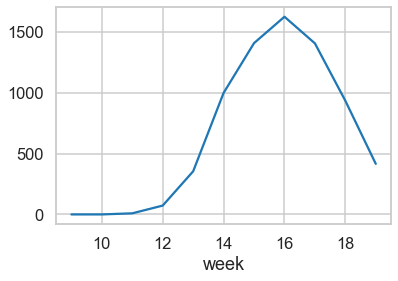

In [61]:
weekly = ger_daily_new_deaths.reset_index()
weekly.columns = ['date', 'deaths']
weekly['week'] = weekly['date'].dt.week
weekly.groupby('week')['deaths'].sum().plot()

## Modelling

In [34]:
ger = ger_daily.iloc[1:].copy()
ger.columns = ['new']
ger['day_of_week'] = ger.index.dayofweek
ger = ger.reset_index()

after_start = datetime(2020, 3, 21)
ger_before = ger[ger['index'] < after_start]
ger_after = ger[ger['index'] >= after_start]

'The model assumes a daily growth of cases by 28%'

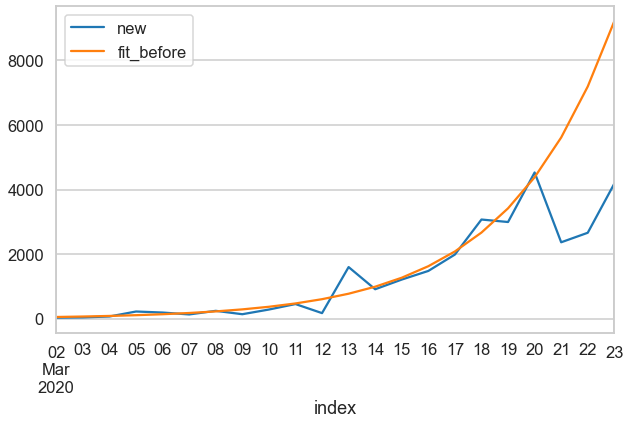

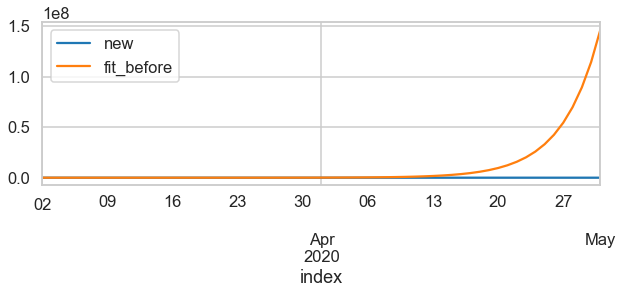

In [10]:
import math
from scipy.optimize import curve_fit
 
def general_exp(t, a, b):
    # t will be a RangeIndex
    return (a * np.exp(b * t))

opt_before, _ = curve_fit(general_exp, ger_before.index, ger_before['new'])

ger['fit_before'] = general_exp(ger.index, *opt_before)
ger[:22].set_index('index')[['new', 'fit_before']].plot(figsize=(10, 6))
ger.set_index('index')[['new', 'fit_before']].plot(figsize=(10, 3))
f'The model assumes a daily growth of cases by {math.exp(opt_before[1]) - 1:.0%}'

'The model assumes a daily growth of cases by 172%'

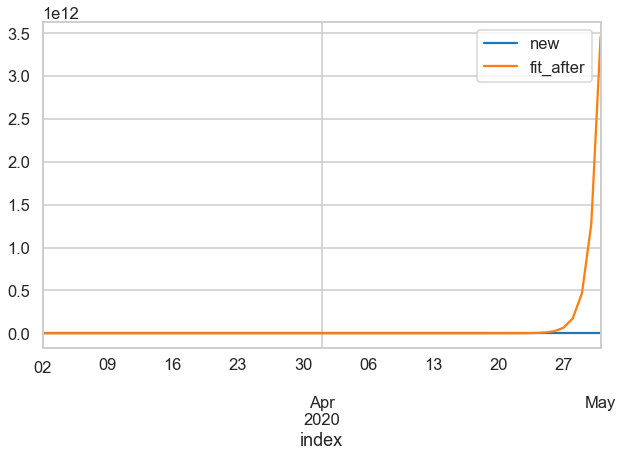

In [11]:
opt_after, _ = curve_fit(general_exp, ger_after.index, ger_after['new'])

ger['fit_after'] = general_exp(ger.index, *opt_after)
ger.set_index('index')[['new', 'fit_after']].plot(figsize=(10, 6))
f'The model assumes a daily growth of cases by {math.exp(opt_after[1]) - 1:.0%}'

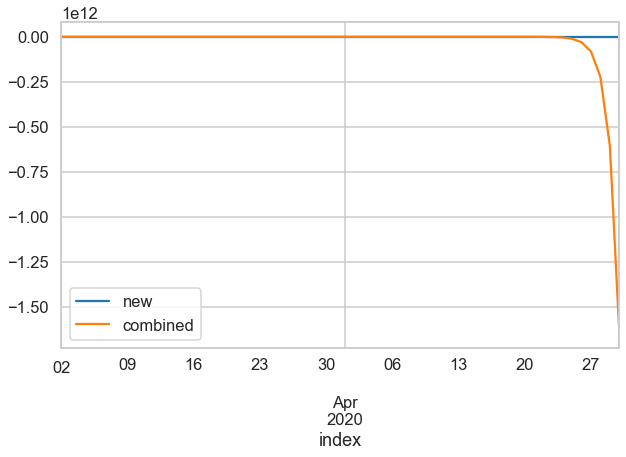

In [12]:
ger['combined'] = ger['fit_before']
ger.loc[ger['index'] >= after_start ,'combined'] = ger['fit_after']
ger.set_index('index')[['new', 'combined']].plot(figsize=(10, 6))

In [13]:
start = ger['index'].min()
date_index = pd.date_range(start, periods=35)
with_future = date_index.to_frame().reset_index(drop=True)
with_future.columns = ['index']
with_future['new cases'] = ger['new']
with_future['model'] = general_exp(with_future.index, *opt_after)
with_future.loc[with_future['index'] < after_start,'model'] = ger.loc[with_future['index'] < after_start,'fit_before']
with_future.set_index('index')[['new cases', 'model']].plot(figsize=(12, 8))
plt.title('Daily New Cases')

with_future.set_index('index')[['new cases', 'model']].cumsum().plot(figsize=(12, 8))
_ = plt.title('Total Cases')

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

## Stored predictions

### Sun 29th of March

In [ ]:
#### Prediction for 3rd of April
Dirk Brockmann: 102K (68%-CI 78k-140k)
My model: 